In [1]:
! pip install pyspellchecker

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.7 MB 6.3 MB/s 


In [2]:
! python -m spacy download en_core_web_lg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 400.7 MB 5.9 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [3]:
! pip install pyLDAvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 7.5 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=dd41c82167b35619bdb42df245dc16a7d27c20784bdcb1349c76919588776be3
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyLDAvis


In [4]:
! pip install tomotopy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 16.3 MB 8.2 MB/s 


In [29]:
# import the package
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import re
import seaborn as sns
# import packages
from sklearn.linear_model import LogisticRegression
from spellchecker import SpellChecker
from collections import Counter, OrderedDict
from sklearn.model_selection import train_test_split
import en_core_web_lg
import spacy 
from sklearn.feature_extraction.text import TfidfVectorizer
import pyLDAvis
from tracemalloc import stop
from langcodes import best_match
from matplotlib import rc
import tomotopy as tp
from gensim.models import Phrases


In [6]:
# load the data
df_train = pd.read_csv('./train.csv')
df_test = pd.read_csv('./test.csv')
# df_submission = pd.read_csv('./submission_file.csv')

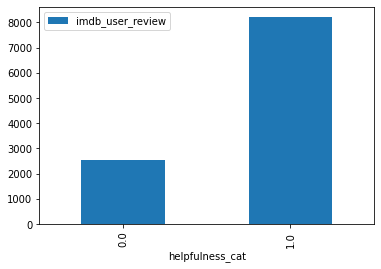

In [ ]:
# check the distribution of the dataset by category
df_train.groupby('helpfulness_cat').count().plot.bar(ylim=0)
plt.show()

In [ ]:
df_test.head()

,_id,imdb_user_review
0,610d01fe9a63eb113d2235ac,This is basically a German takeoff on a Sherlo...
1,610d01fe9a63eb113d224536,"In January of 1924, director Erich von Strohei..."
2,610d01fe9a63eb113d224d14,Silent movies are not for everyone. Neither ar...
3,610d01fe9a63eb113d225f17,It so often happens that some films take the l...
4,610d01fe9a63eb113d225f1a,I saw this film for the very first time last w...


In [7]:
nlp = spacy.load("en_core_web_lg")

In [8]:
# separate x and y
review_text = df_train['imdb_user_review']
review_cat = df_train['helpfulness_cat']

### Preprocessing text

In [ ]:
# define a data cleaning function
def clean_data(reviews):
    # # step 1: separate x and y
    # convert review_text df to list
    reviews = reviews.to_list()
    
    # step 2: nromalize the review
    print(f"Total voc number: {len(reviews)}")
    reviews = list(map(lambda x: x.lower(),reviews))

    # step 3: remove Unicode Characters (punctuation, emoji,rul and @) 
    reviews = list(map(lambda x: re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", x),reviews))

    # step 4: remove whitespaces and trailing spaces
    def remove_whitespace(text):
        pattern = re.compile(r'\s+') 
        Without_whitespace = re.sub(pattern, ' ', text)
        text = Without_whitespace.replace('?', ' ? ').replace(')', ') ')
        text = text.strip()
        return text
    reviews=list(map(lambda x: remove_whitespace(x),reviews))
                                                                                                                                                                                                                                                                                                    
    # step 5: apply nlp pipeline remove stop words, numbers and lematize the words
    
    # expand the list of stopwords
    gist_file = open("gist_stopwords.txt", "r")
    try:
        content = gist_file.read()
        stopwords = content.split(",")
    finally:
        gist_file.close()
      
    stopwords=[i.replace('"',"").strip() for i in stopwords]
    # add the stopwords to the list of stopwords
    for i in stopwords:
      nlp.Defaults.stop_words.add(i)

    # create colloum for cleaned reviews
    reviews_tokens, tmp_tokens = [], [] 
    for review in tqdm.tqdm(reviews):
        tmp_tokens = [
            token.lemma_
            for token in nlp(review)
            if not token.is_stop 
            and not token.like_num
            and not token.is_punct
            and token.is_alpha
            ]
        reviews_tokens.append(tmp_tokens)
        tmp_tokens=[]
        
    # # convert list back to df 
    # reviews = pd.DataFrame({'imbd_user_review':reviews_tokens})

    return reviews_tokens

In [ ]:
train = clean_data(review_text)

In [ ]:
# create a dataframe for analysis
reviews = pd.DataFrame({'imbd_user_review':train,'helpfulness_cat':review_cat})

In [ ]:
# build spell checker and create spell mistakes
spell = SpellChecker()
mdy_train, temp_train = [], []
for comment in tqdm.tqdm(train):
    temp_train = [word if word in spell else spell.correction(word) for word in comment]
    mdy_train.append(temp_train)
    temp_train=[]
# spell.word_frequency.remove('aka')

In [ ]:
import pickle
file_name='correct_train2.txt'
with open(file_name, "wb") as fp:   #Pickling
    pickle.dump(mdy_train, fp)

In [12]:
import pickle
with open('correct_train2.txt','rb') as fp:
  mdy_train = pickle.load(fp)

In [13]:
# remove bracket within the list
tokens_list = [", ".join(token) for token in mdy_train]

## Feature Enginerring

### Word Frequency Analysis

In [67]:
# explore word frequencies
word_freq = Counter(x for xs in mdy_train_2 for x in set(xs)).most_common()
word_fr = pd.DataFrame(word_freq, columns=['word', 'freq']).sort_values(by='freq', ascending=False)
word_fr


,word,freq
0,watch,3589
1,story,3401
2,time,3383
3,good,3127
4,character,2872
...,...,...
28825,antarctic,1
28824,tugging,1
28823,glaciercovered,1
28822,edifice,1


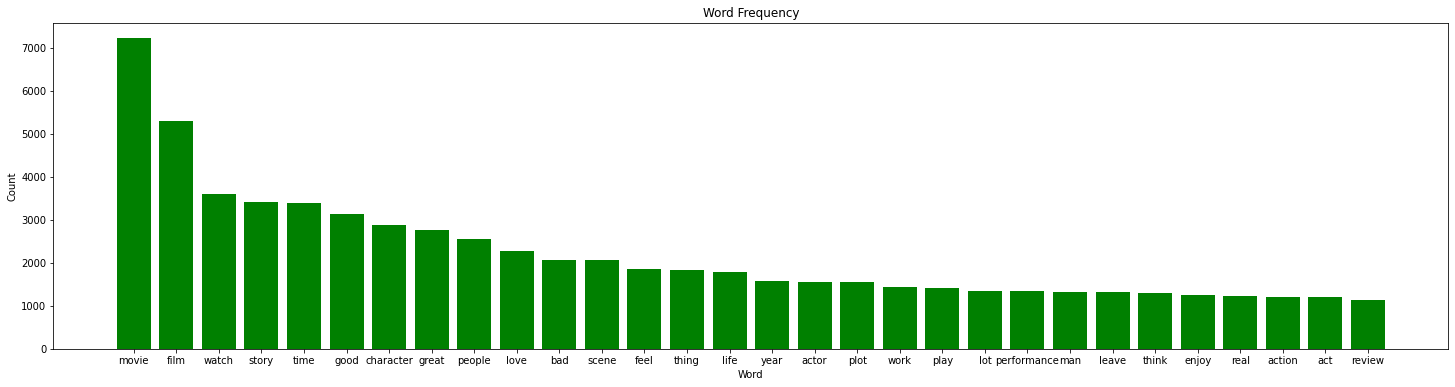

In [31]:
# visualize word frequencies
# figure size
fig = plt.figure(figsize=(25, 6))
plt.bar(word_fr.word[0:30], word_fr.freq[0:30], color='green')
plt.xlabel("Word")
plt.ylabel("Count")
plt.title("Word Frequency")
plt.show()



In [65]:
# remove most frequent words which is known in this context
word_list=['movie','film']
mdy_train_2, tmp=[],[]
for review in mdy_train:
    for word in review:
        if word not in word_list:
            tmp.append(word)
    mdy_train_2.append(tmp)
    tmp=[]

In [68]:
# remove bracket within the list
tokens_list = [", ".join(token) for token in mdy_train_2]

### Topic Modeling

In [69]:
# get rid of common terms
common_terms = [
    u"of",
    u"with",
    u"without",
    u"and",
    u"or",
    u"the",
    u"a",
    u"not",
    "be",
    u"to",
    u"this",
    u"who",
    u"in",
]
## find phrases
# find bigram first
bigram = Phrases(
    mdy_train_2,
    min_count=50,
    threshold=5,
    max_vocab_size=50000,
    common_terms=common_terms,
)
# find trigram
trigram = Phrases(
    bigram[mdy_train_2],
    min_count=50,
    threshold=5,
    max_vocab_size=50000,
    common_terms=common_terms,
)

#option 1
# uncomment if bi-grammed, tokenized document is preferred
# docs_phrased = [bigram[line] for line in docs_tokens]

#option 2
docs_phrased = [trigram[bigram[line]] for line in mdy_train_2]

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [73]:
# create a corpus using Tomotopy utils
# empty corpus
corpus = tp.utils.Corpus()
# populate the corpus
for item in docs_phrased:
    corpus.add_doc(words=item)

# topic modeling ― explore model validity
# register "UMass" coherence scores
cvs = {}
for topic_number in tqdm.tqdm(range(1, 100, 1)):
    mdl = tp.LDAModel(k=topic_number, corpus=corpus)
    for i in range(0, 100, 10):
        mdl.train(10)
        print("Iteration: {}\tLog-likelihood: {}".format(i, mdl.ll_per_word))
    coh = tp.coherence.Coherence(mdl, coherence='c_v') #c_v
    cvs[topic_number] = coh.get_score()

  0%|          | 0/99 [00:00<?, ?it/s]

Iteration: 0	Log-likelihood: -8.755157792183217
Iteration: 10	Log-likelihood: -8.755157792183217
Iteration: 20	Log-likelihood: -8.755157792183217
Iteration: 30	Log-likelihood: -8.755157792183217
Iteration: 40	Log-likelihood: -8.755157792183217
Iteration: 50	Log-likelihood: -8.755157792183217
Iteration: 60	Log-likelihood: -8.755157792183217


  1%|          | 1/99 [00:02<03:47,  2.32s/it]

Iteration: 70	Log-likelihood: -8.755157792183217
Iteration: 80	Log-likelihood: -8.755157792183217
Iteration: 90	Log-likelihood: -8.755157792183217
Iteration: 0	Log-likelihood: -9.201331694187818
Iteration: 10	Log-likelihood: -9.121030897053183
Iteration: 20	Log-likelihood: -9.030525541848691
Iteration: 30	Log-likelihood: -8.979540792291408
Iteration: 40	Log-likelihood: -8.949389946863166
Iteration: 50	Log-likelihood: -8.934344974976181
Iteration: 60	Log-likelihood: -8.922688600190774
Iteration: 70	Log-likelihood: -8.915530250554088
Iteration: 80	Log-likelihood: -8.909403029960579
Iteration: 90	Log-likelihood: -8.905645357562431


  2%|▏         | 2/99 [00:05<04:19,  2.68s/it]

Iteration: 0	Log-likelihood: -9.431499736504943
Iteration: 10	Log-likelihood: -9.323732756810605
Iteration: 20	Log-likelihood: -9.180404482510681
Iteration: 30	Log-likelihood: -9.091345781553686
Iteration: 40	Log-likelihood: -9.045461004512095
Iteration: 50	Log-likelihood: -9.020872527245913
Iteration: 60	Log-likelihood: -9.00473999307164


  3%|▎         | 3/99 [00:08<04:22,  2.74s/it]

Iteration: 70	Log-likelihood: -8.992487084501251
Iteration: 80	Log-likelihood: -8.984445387779564
Iteration: 90	Log-likelihood: -8.980554325321808
Iteration: 0	Log-likelihood: -9.571747054117537
Iteration: 10	Log-likelihood: -9.463797466110096
Iteration: 20	Log-likelihood: -9.333027910422848
Iteration: 30	Log-likelihood: -9.239329421488048
Iteration: 40	Log-likelihood: -9.182382243554724
Iteration: 50	Log-likelihood: -9.143384037585074
Iteration: 60	Log-likelihood: -9.120030296031254
Iteration: 70	Log-likelihood: -9.099962265232879


  4%|▍         | 4/99 [00:10<04:14,  2.68s/it]

Iteration: 80	Log-likelihood: -9.08769145016102
Iteration: 90	Log-likelihood: -9.083109725627393
Iteration: 0	Log-likelihood: -9.662370870939661
Iteration: 10	Log-likelihood: -9.496490955758851
Iteration: 20	Log-likelihood: -9.348192520465942
Iteration: 30	Log-likelihood: -9.24477784261669
Iteration: 40	Log-likelihood: -9.18487759528844
Iteration: 50	Log-likelihood: -9.14668533854776
Iteration: 60	Log-likelihood: -9.124078835899226
Iteration: 70	Log-likelihood: -9.107839087007944
Iteration: 80	Log-likelihood: -9.09412376292257
Iteration: 90	Log-likelihood: -9.085218991856859


  5%|▌         | 5/99 [00:13<04:18,  2.75s/it]

Iteration: 0	Log-likelihood: -9.743354719170755
Iteration: 10	Log-likelihood: -9.55863420001896
Iteration: 20	Log-likelihood: -9.401138879892649
Iteration: 30	Log-likelihood: -9.306502001798693
Iteration: 40	Log-likelihood: -9.24761197666803
Iteration: 50	Log-likelihood: -9.209892257548464
Iteration: 60	Log-likelihood: -9.182408143903398
Iteration: 70	Log-likelihood: -9.163146146918875
Iteration: 80	Log-likelihood: -9.149634580847067
Iteration: 90	Log-likelihood: -9.140550912425752


  6%|▌         | 6/99 [00:16<04:26,  2.87s/it]

Iteration: 0	Log-likelihood: -9.801219268536066
Iteration: 10	Log-likelihood: -9.590410642823079
Iteration: 20	Log-likelihood: -9.424365107141401
Iteration: 30	Log-likelihood: -9.340683567634418
Iteration: 40	Log-likelihood: -9.288023253927134
Iteration: 50	Log-likelihood: -9.255108786222566
Iteration: 60	Log-likelihood: -9.228935935762216
Iteration: 70	Log-likelihood: -9.210688149853548


  7%|▋         | 7/99 [00:19<04:36,  3.01s/it]

Iteration: 80	Log-likelihood: -9.19180276044656
Iteration: 90	Log-likelihood: -9.185025595990833
Iteration: 0	Log-likelihood: -9.85226185540093
Iteration: 10	Log-likelihood: -9.646854450471752
Iteration: 20	Log-likelihood: -9.470042898614182
Iteration: 30	Log-likelihood: -9.376202081061171
Iteration: 40	Log-likelihood: -9.317689758095158
Iteration: 50	Log-likelihood: -9.275536520566678
Iteration: 60	Log-likelihood: -9.251129951804149
Iteration: 70	Log-likelihood: -9.2269627579658
Iteration: 80	Log-likelihood: -9.207928966451165
Iteration: 90	Log-likelihood: -9.19450125439691


  8%|▊         | 8/99 [00:22<04:31,  2.98s/it]

Iteration: 0	Log-likelihood: -9.891154284782948
Iteration: 10	Log-likelihood: -9.658901690008248
Iteration: 20	Log-likelihood: -9.485850687328812
Iteration: 30	Log-likelihood: -9.397708346816994
Iteration: 40	Log-likelihood: -9.347019605911704
Iteration: 50	Log-likelihood: -9.310761987454349
Iteration: 60	Log-likelihood: -9.277646862583772
Iteration: 70	Log-likelihood: -9.254062893263711
Iteration: 80	Log-likelihood: -9.240603488390992
Iteration: 90	Log-likelihood: -9.226069770116057


  9%|▉         | 9/99 [00:25<04:32,  3.03s/it]

Iteration: 0	Log-likelihood: -9.917265910659493
Iteration: 10	Log-likelihood: -9.68598452837505
Iteration: 20	Log-likelihood: -9.530116922928077
Iteration: 30	Log-likelihood: -9.433593332161959
Iteration: 40	Log-likelihood: -9.377426881814909
Iteration: 50	Log-likelihood: -9.337081222451097
Iteration: 60	Log-likelihood: -9.300675202074116
Iteration: 70	Log-likelihood: -9.27399367899811
Iteration: 80	Log-likelihood: -9.248894422072546
Iteration: 90	Log-likelihood: -9.235034315218158


 10%|█         | 10/99 [00:29<04:41,  3.17s/it]

Iteration: 0	Log-likelihood: -9.946696707408037
Iteration: 10	Log-likelihood: -9.690542337678888
Iteration: 20	Log-likelihood: -9.533549094693536
Iteration: 30	Log-likelihood: -9.440762494964071
Iteration: 40	Log-likelihood: -9.379014644498543
Iteration: 50	Log-likelihood: -9.337549668501838
Iteration: 60	Log-likelihood: -9.302197919177738
Iteration: 70	Log-likelihood: -9.278991008726065
Iteration: 80	Log-likelihood: -9.261017232983326
Iteration: 90	Log-likelihood: -9.246910126813153


 11%|█         | 11/99 [00:33<04:56,  3.37s/it]

Iteration: 0	Log-likelihood: -9.959331229418225
Iteration: 10	Log-likelihood: -9.699212940551194
Iteration: 20	Log-likelihood: -9.549765144900544
Iteration: 30	Log-likelihood: -9.465721376869539
Iteration: 40	Log-likelihood: -9.411653381909861
Iteration: 50	Log-likelihood: -9.373391603718675
Iteration: 60	Log-likelihood: -9.339246324515152
Iteration: 70	Log-likelihood: -9.311868729426221
Iteration: 80	Log-likelihood: -9.295621666579118
Iteration: 90	Log-likelihood: -9.278827491905012


 12%|█▏        | 12/99 [00:37<05:14,  3.61s/it]

Iteration: 0	Log-likelihood: -9.991569241717562
Iteration: 10	Log-likelihood: -9.751912048445755
Iteration: 20	Log-likelihood: -9.598620785723268
Iteration: 30	Log-likelihood: -9.501902065586052
Iteration: 40	Log-likelihood: -9.445507057604855
Iteration: 50	Log-likelihood: -9.3977291062295
Iteration: 60	Log-likelihood: -9.364501804015273
Iteration: 70	Log-likelihood: -9.340143239699682
Iteration: 80	Log-likelihood: -9.317136979170101
Iteration: 90	Log-likelihood: -9.302231113935106


 13%|█▎        | 13/99 [00:42<05:41,  3.97s/it]

Iteration: 0	Log-likelihood: -10.017066280792779
Iteration: 10	Log-likelihood: -9.768141467938502
Iteration: 20	Log-likelihood: -9.608657988875992
Iteration: 30	Log-likelihood: -9.514457329292195
Iteration: 40	Log-likelihood: -9.444924265253352
Iteration: 50	Log-likelihood: -9.40077084964832
Iteration: 60	Log-likelihood: -9.364366589915308
Iteration: 70	Log-likelihood: -9.336563051218642
Iteration: 80	Log-likelihood: -9.318391769138817
Iteration: 90	Log-likelihood: -9.295554504767823


 14%|█▍        | 14/99 [00:47<06:14,  4.41s/it]

Iteration: 0	Log-likelihood: -10.036571801451602
Iteration: 10	Log-likelihood: -9.784666037132057
Iteration: 20	Log-likelihood: -9.639359478884304
Iteration: 30	Log-likelihood: -9.550097777522947
Iteration: 40	Log-likelihood: -9.484092076419893
Iteration: 50	Log-likelihood: -9.436809740938662
Iteration: 60	Log-likelihood: -9.399831655144833
Iteration: 70	Log-likelihood: -9.373193586297488
Iteration: 80	Log-likelihood: -9.352826233312397
Iteration: 90	Log-likelihood: -9.33448916606312


 15%|█▌        | 15/99 [00:53<06:37,  4.73s/it]

Iteration: 0	Log-likelihood: -10.05128583099049
Iteration: 10	Log-likelihood: -9.791593937029575
Iteration: 20	Log-likelihood: -9.62995287520871
Iteration: 30	Log-likelihood: -9.534744859186143
Iteration: 40	Log-likelihood: -9.472047706492429
Iteration: 50	Log-likelihood: -9.424058639896577
Iteration: 60	Log-likelihood: -9.392173058553547
Iteration: 70	Log-likelihood: -9.36044296264146
Iteration: 80	Log-likelihood: -9.34084912214598
Iteration: 90	Log-likelihood: -9.324560793069878


 16%|█▌        | 16/99 [00:58<06:36,  4.77s/it]

Iteration: 0	Log-likelihood: -10.065808256362601
Iteration: 10	Log-likelihood: -9.817569592450566
Iteration: 20	Log-likelihood: -9.656048169001942
Iteration: 30	Log-likelihood: -9.560820884086224
Iteration: 40	Log-likelihood: -9.495355657661582
Iteration: 50	Log-likelihood: -9.442135908540685
Iteration: 60	Log-likelihood: -9.403062535625978
Iteration: 70	Log-likelihood: -9.37548945654937
Iteration: 80	Log-likelihood: -9.350136136538792
Iteration: 90	Log-likelihood: -9.328898085774103


 17%|█▋        | 17/99 [01:03<06:41,  4.89s/it]

Iteration: 0	Log-likelihood: -10.078170997094583
Iteration: 10	Log-likelihood: -9.806366770069854
Iteration: 20	Log-likelihood: -9.666178251407725
Iteration: 30	Log-likelihood: -9.575968502400936
Iteration: 40	Log-likelihood: -9.516497766807582
Iteration: 50	Log-likelihood: -9.467084907377156
Iteration: 60	Log-likelihood: -9.434480162930182
Iteration: 70	Log-likelihood: -9.404077406144399
Iteration: 80	Log-likelihood: -9.381457946880468
Iteration: 90	Log-likelihood: -9.36126187501248


 18%|█▊        | 18/99 [01:09<07:15,  5.38s/it]

Iteration: 0	Log-likelihood: -10.091213839390571
Iteration: 10	Log-likelihood: -9.805652947602029
Iteration: 20	Log-likelihood: -9.64953304565642
Iteration: 30	Log-likelihood: -9.559647354449984
Iteration: 40	Log-likelihood: -9.494969667827283
Iteration: 50	Log-likelihood: -9.446508493694163
Iteration: 60	Log-likelihood: -9.408400498887772
Iteration: 70	Log-likelihood: -9.377867131493892
Iteration: 80	Log-likelihood: -9.346879790836738
Iteration: 90	Log-likelihood: -9.327851940861141


 19%|█▉        | 19/99 [01:16<07:52,  5.90s/it]

Iteration: 0	Log-likelihood: -10.113866729092132
Iteration: 10	Log-likelihood: -9.852751977812822
Iteration: 20	Log-likelihood: -9.694327897355015
Iteration: 30	Log-likelihood: -9.601552447483122
Iteration: 40	Log-likelihood: -9.535611973938954
Iteration: 50	Log-likelihood: -9.485274273488224
Iteration: 60	Log-likelihood: -9.444894358478493
Iteration: 70	Log-likelihood: -9.415190393422453
Iteration: 80	Log-likelihood: -9.390457043105206
Iteration: 90	Log-likelihood: -9.370082476505884


 20%|██        | 20/99 [01:24<08:35,  6.52s/it]

Iteration: 0	Log-likelihood: -10.115639219433767
Iteration: 10	Log-likelihood: -9.836642807415247
Iteration: 20	Log-likelihood: -9.675299137779234
Iteration: 30	Log-likelihood: -9.57700219897676
Iteration: 40	Log-likelihood: -9.511632499846462
Iteration: 50	Log-likelihood: -9.457771906882979
Iteration: 60	Log-likelihood: -9.415575766597964
Iteration: 70	Log-likelihood: -9.383451275352197
Iteration: 80	Log-likelihood: -9.353426955571262
Iteration: 90	Log-likelihood: -9.335861731098891


 21%|██        | 21/99 [01:34<09:48,  7.55s/it]

Iteration: 0	Log-likelihood: -10.135972797149686
Iteration: 10	Log-likelihood: -9.866090946590655
Iteration: 20	Log-likelihood: -9.710259844995946
Iteration: 30	Log-likelihood: -9.617161200055913
Iteration: 40	Log-likelihood: -9.541561849071314
Iteration: 50	Log-likelihood: -9.48799033110361
Iteration: 60	Log-likelihood: -9.449179304092597
Iteration: 70	Log-likelihood: -9.417775745453518
Iteration: 80	Log-likelihood: -9.387912643151548
Iteration: 90	Log-likelihood: -9.36579557568892


 22%|██▏       | 22/99 [01:43<10:15,  7.99s/it]

Iteration: 0	Log-likelihood: -10.150692180425205
Iteration: 10	Log-likelihood: -9.881175299584585
Iteration: 20	Log-likelihood: -9.727361278640078
Iteration: 30	Log-likelihood: -9.632852912220146
Iteration: 40	Log-likelihood: -9.56941101201266
Iteration: 50	Log-likelihood: -9.522412494906362
Iteration: 60	Log-likelihood: -9.483717703580535
Iteration: 70	Log-likelihood: -9.447285874853415
Iteration: 80	Log-likelihood: -9.417017374774826
Iteration: 90	Log-likelihood: -9.39620364130741


 23%|██▎       | 23/99 [01:54<11:09,  8.81s/it]

Iteration: 0	Log-likelihood: -10.150248282613271
Iteration: 10	Log-likelihood: -9.868317616556128
Iteration: 20	Log-likelihood: -9.72376868246709
Iteration: 30	Log-likelihood: -9.63012208613293
Iteration: 40	Log-likelihood: -9.568935319362092
Iteration: 50	Log-likelihood: -9.515832826047976
Iteration: 60	Log-likelihood: -9.479381931545158
Iteration: 70	Log-likelihood: -9.445997975251696
Iteration: 80	Log-likelihood: -9.42047521157479
Iteration: 90	Log-likelihood: -9.395023822246632


 24%|██▍       | 24/99 [02:06<12:06,  9.69s/it]

Iteration: 0	Log-likelihood: -10.160913010460193
Iteration: 10	Log-likelihood: -9.88737983796521
Iteration: 20	Log-likelihood: -9.744576990707357
Iteration: 30	Log-likelihood: -9.650499255251043
Iteration: 40	Log-likelihood: -9.578480788120894
Iteration: 50	Log-likelihood: -9.525016392701886
Iteration: 60	Log-likelihood: -9.477365454392757
Iteration: 70	Log-likelihood: -9.441203266832964
Iteration: 80	Log-likelihood: -9.40996607567507
Iteration: 90	Log-likelihood: -9.382878703038273


 25%|██▌       | 25/99 [02:17<12:42, 10.30s/it]

Iteration: 0	Log-likelihood: -10.178343168578527
Iteration: 10	Log-likelihood: -9.891307633867454
Iteration: 20	Log-likelihood: -9.738475708123978
Iteration: 30	Log-likelihood: -9.652826884502302
Iteration: 40	Log-likelihood: -9.582811665358694
Iteration: 50	Log-likelihood: -9.531880166791911
Iteration: 60	Log-likelihood: -9.482656437319369
Iteration: 70	Log-likelihood: -9.447656076996012
Iteration: 80	Log-likelihood: -9.413697852316734
Iteration: 90	Log-likelihood: -9.386222760957375


 26%|██▋       | 26/99 [02:29<13:04, 10.74s/it]

Iteration: 0	Log-likelihood: -10.176319262578373
Iteration: 10	Log-likelihood: -9.889119588652955
Iteration: 20	Log-likelihood: -9.737743795675232
Iteration: 30	Log-likelihood: -9.646816870165592
Iteration: 40	Log-likelihood: -9.582331976505154
Iteration: 50	Log-likelihood: -9.52990708095472
Iteration: 60	Log-likelihood: -9.488170476299095
Iteration: 70	Log-likelihood: -9.452208811296833
Iteration: 80	Log-likelihood: -9.421865533355952
Iteration: 90	Log-likelihood: -9.396308537191675


 27%|██▋       | 27/99 [02:42<13:41, 11.41s/it]

Iteration: 0	Log-likelihood: -10.19579716681961
Iteration: 10	Log-likelihood: -9.905691406200178
Iteration: 20	Log-likelihood: -9.751569150887116
Iteration: 30	Log-likelihood: -9.648550205263426
Iteration: 40	Log-likelihood: -9.582250269972317
Iteration: 50	Log-likelihood: -9.526415239628262
Iteration: 60	Log-likelihood: -9.487250203935757
Iteration: 70	Log-likelihood: -9.458791756891543
Iteration: 80	Log-likelihood: -9.430917465599451
Iteration: 90	Log-likelihood: -9.409164249080987


 28%|██▊       | 28/99 [02:58<14:56, 12.62s/it]

Iteration: 0	Log-likelihood: -10.206489340536793
Iteration: 10	Log-likelihood: -9.918489321671986
Iteration: 20	Log-likelihood: -9.771097102141796
Iteration: 30	Log-likelihood: -9.680708521023924
Iteration: 40	Log-likelihood: -9.613203028817281
Iteration: 50	Log-likelihood: -9.558673200864812
Iteration: 60	Log-likelihood: -9.51876951898948
Iteration: 70	Log-likelihood: -9.48340806899057
Iteration: 80	Log-likelihood: -9.45284054368162
Iteration: 90	Log-likelihood: -9.425583972077666


 29%|██▉       | 29/99 [03:14<16:07, 13.83s/it]

Iteration: 0	Log-likelihood: -10.207431647525715
Iteration: 10	Log-likelihood: -9.915582575841038
Iteration: 20	Log-likelihood: -9.770704700984336
Iteration: 30	Log-likelihood: -9.679310330973696
Iteration: 40	Log-likelihood: -9.616967255121603
Iteration: 50	Log-likelihood: -9.562651944632252
Iteration: 60	Log-likelihood: -9.51508664641607
Iteration: 70	Log-likelihood: -9.481830022483969
Iteration: 80	Log-likelihood: -9.454666603607913
Iteration: 90	Log-likelihood: -9.435051088033257


 30%|███       | 30/99 [03:32<17:19, 15.06s/it]

Iteration: 0	Log-likelihood: -10.221963118339401
Iteration: 10	Log-likelihood: -9.92635314441246
Iteration: 20	Log-likelihood: -9.77347504419879
Iteration: 30	Log-likelihood: -9.680223410426615
Iteration: 40	Log-likelihood: -9.616375719149595
Iteration: 50	Log-likelihood: -9.561239588746021
Iteration: 60	Log-likelihood: -9.520883518913191
Iteration: 70	Log-likelihood: -9.484834547770584
Iteration: 80	Log-likelihood: -9.451975374182787
Iteration: 90	Log-likelihood: -9.42633898435022


 31%|███▏      | 31/99 [03:55<19:45, 17.44s/it]

Iteration: 0	Log-likelihood: -10.228027256030467
Iteration: 10	Log-likelihood: -9.933402296453547
Iteration: 20	Log-likelihood: -9.786397609252852
Iteration: 30	Log-likelihood: -9.69373171999412
Iteration: 40	Log-likelihood: -9.625800368355613
Iteration: 50	Log-likelihood: -9.571535331787727
Iteration: 60	Log-likelihood: -9.528446247922684
Iteration: 70	Log-likelihood: -9.492718369519762
Iteration: 80	Log-likelihood: -9.458484737085694
Iteration: 90	Log-likelihood: -9.429699849715375


 32%|███▏      | 32/99 [04:16<20:39, 18.50s/it]

Iteration: 0	Log-likelihood: -10.233513608736253
Iteration: 10	Log-likelihood: -9.94108717415934
Iteration: 20	Log-likelihood: -9.787548301653462
Iteration: 30	Log-likelihood: -9.694434337809827
Iteration: 40	Log-likelihood: -9.62520959753624
Iteration: 50	Log-likelihood: -9.570571066531466
Iteration: 60	Log-likelihood: -9.527087754886162
Iteration: 70	Log-likelihood: -9.485298588126007
Iteration: 80	Log-likelihood: -9.45459156988974
Iteration: 90	Log-likelihood: -9.429409603868304


 33%|███▎      | 33/99 [04:41<22:21, 20.33s/it]

Iteration: 0	Log-likelihood: -10.249477570474244
Iteration: 10	Log-likelihood: -9.948022691337854
Iteration: 20	Log-likelihood: -9.792137302125631
Iteration: 30	Log-likelihood: -9.699103798487783
Iteration: 40	Log-likelihood: -9.632256484229455
Iteration: 50	Log-likelihood: -9.582765195674641
Iteration: 60	Log-likelihood: -9.538696431490449
Iteration: 70	Log-likelihood: -9.501579538226245
Iteration: 80	Log-likelihood: -9.474559547945162
Iteration: 90	Log-likelihood: -9.446188204132502


 34%|███▍      | 34/99 [05:05<23:08, 21.35s/it]

Iteration: 0	Log-likelihood: -10.238817385842063
Iteration: 10	Log-likelihood: -9.934752737674664
Iteration: 20	Log-likelihood: -9.788544857491505
Iteration: 30	Log-likelihood: -9.692407188036738
Iteration: 40	Log-likelihood: -9.62512299543356
Iteration: 50	Log-likelihood: -9.574416043916015
Iteration: 60	Log-likelihood: -9.53518431708041
Iteration: 70	Log-likelihood: -9.496102302280612
Iteration: 80	Log-likelihood: -9.467284322460591
Iteration: 90	Log-likelihood: -9.437204826644756


 35%|███▌      | 35/99 [05:34<25:26, 23.86s/it]

Iteration: 0	Log-likelihood: -10.253144301511853
Iteration: 10	Log-likelihood: -9.945082235844247
Iteration: 20	Log-likelihood: -9.7915334581203
Iteration: 30	Log-likelihood: -9.699954968033333
Iteration: 40	Log-likelihood: -9.631493817539525
Iteration: 50	Log-likelihood: -9.585085688095784
Iteration: 60	Log-likelihood: -9.54077334658298
Iteration: 70	Log-likelihood: -9.505774342010039
Iteration: 80	Log-likelihood: -9.480248922901303
Iteration: 90	Log-likelihood: -9.453811660840563


 36%|███▋      | 36/99 [06:02<26:09, 24.91s/it]

Iteration: 0	Log-likelihood: -10.253374590828777
Iteration: 10	Log-likelihood: -9.959046097605269
Iteration: 20	Log-likelihood: -9.809891137046105
Iteration: 30	Log-likelihood: -9.712334979548666
Iteration: 40	Log-likelihood: -9.63758466514551
Iteration: 50	Log-likelihood: -9.580954303735544
Iteration: 60	Log-likelihood: -9.53247188178893
Iteration: 70	Log-likelihood: -9.493238866246996
Iteration: 80	Log-likelihood: -9.462271628010884
Iteration: 90	Log-likelihood: -9.436472134293934


 37%|███▋      | 37/99 [06:29<26:30, 25.65s/it]

Iteration: 0	Log-likelihood: -10.272246886616799
Iteration: 10	Log-likelihood: -9.973471011762141
Iteration: 20	Log-likelihood: -9.814201188944706
Iteration: 30	Log-likelihood: -9.711088907590893
Iteration: 40	Log-likelihood: -9.643318586848443
Iteration: 50	Log-likelihood: -9.594060658447273
Iteration: 60	Log-likelihood: -9.552538130146107
Iteration: 70	Log-likelihood: -9.516238736541057
Iteration: 80	Log-likelihood: -9.48532796444598
Iteration: 90	Log-likelihood: -9.459920827926794


 38%|███▊      | 38/99 [07:00<27:44, 27.28s/it]

Iteration: 0	Log-likelihood: -10.269050014717505
Iteration: 10	Log-likelihood: -9.955513876978879
Iteration: 20	Log-likelihood: -9.798757715800013
Iteration: 30	Log-likelihood: -9.697204816285485
Iteration: 40	Log-likelihood: -9.63284696423173
Iteration: 50	Log-likelihood: -9.58209776397165
Iteration: 60	Log-likelihood: -9.536645886313826
Iteration: 70	Log-likelihood: -9.500400626939278
Iteration: 80	Log-likelihood: -9.468708634922512
Iteration: 90	Log-likelihood: -9.443195580317681


 39%|███▉      | 39/99 [07:23<25:55, 25.92s/it]

Iteration: 0	Log-likelihood: -10.290627910101612
Iteration: 10	Log-likelihood: -9.984329799222662
Iteration: 20	Log-likelihood: -9.833423646171642
Iteration: 30	Log-likelihood: -9.733699354264918
Iteration: 40	Log-likelihood: -9.658201148398017
Iteration: 50	Log-likelihood: -9.603520908153683
Iteration: 60	Log-likelihood: -9.553251440481715
Iteration: 70	Log-likelihood: -9.5205415455881
Iteration: 80	Log-likelihood: -9.490454999110456
Iteration: 90	Log-likelihood: -9.461849932508633


 40%|████      | 40/99 [07:59<28:27, 28.93s/it]

Iteration: 0	Log-likelihood: -10.293639218508048
Iteration: 10	Log-likelihood: -9.98897192523252
Iteration: 20	Log-likelihood: -9.840561668297324
Iteration: 30	Log-likelihood: -9.74982056573819
Iteration: 40	Log-likelihood: -9.684773916438946
Iteration: 50	Log-likelihood: -9.636172083206825
Iteration: 60	Log-likelihood: -9.59626555060667
Iteration: 70	Log-likelihood: -9.559601133944795
Iteration: 80	Log-likelihood: -9.529076776502487
Iteration: 90	Log-likelihood: -9.501965741797706


 41%|████▏     | 41/99 [08:27<27:53, 28.86s/it]

Iteration: 0	Log-likelihood: -10.295797046455421
Iteration: 10	Log-likelihood: -9.992390507743862
Iteration: 20	Log-likelihood: -9.845650118831657
Iteration: 30	Log-likelihood: -9.758598690036068
Iteration: 40	Log-likelihood: -9.690210348165982
Iteration: 50	Log-likelihood: -9.631404732271921
Iteration: 60	Log-likelihood: -9.584863328621847
Iteration: 70	Log-likelihood: -9.552144728671342
Iteration: 80	Log-likelihood: -9.517834140844867
Iteration: 90	Log-likelihood: -9.490134804508179


 42%|████▏     | 42/99 [09:04<29:44, 31.30s/it]

Iteration: 0	Log-likelihood: -10.299382728965208
Iteration: 10	Log-likelihood: -9.986155629023942
Iteration: 20	Log-likelihood: -9.834559670741488
Iteration: 30	Log-likelihood: -9.737672601890925
Iteration: 40	Log-likelihood: -9.667039829835618
Iteration: 50	Log-likelihood: -9.613607263489106
Iteration: 60	Log-likelihood: -9.575274160554288
Iteration: 70	Log-likelihood: -9.534566257359105
Iteration: 80	Log-likelihood: -9.502847144863914
Iteration: 90	Log-likelihood: -9.482645807357414


 43%|████▎     | 43/99 [09:42<31:00, 33.22s/it]

Iteration: 0	Log-likelihood: -10.301662239592597
Iteration: 10	Log-likelihood: -9.999624843158465
Iteration: 20	Log-likelihood: -9.84517177514817
Iteration: 30	Log-likelihood: -9.743805727286828
Iteration: 40	Log-likelihood: -9.673127281634253
Iteration: 50	Log-likelihood: -9.617923940436548
Iteration: 60	Log-likelihood: -9.580478369272063
Iteration: 70	Log-likelihood: -9.53565240903558
Iteration: 80	Log-likelihood: -9.50081720125228
Iteration: 90	Log-likelihood: -9.474166821423205


 44%|████▍     | 44/99 [10:24<32:46, 35.75s/it]

Iteration: 0	Log-likelihood: -10.312535087592435
Iteration: 10	Log-likelihood: -10.001034452239265
Iteration: 20	Log-likelihood: -9.847748024458896
Iteration: 30	Log-likelihood: -9.753986720363693
Iteration: 40	Log-likelihood: -9.680974326060344
Iteration: 50	Log-likelihood: -9.625645989672838
Iteration: 60	Log-likelihood: -9.573839795702114
Iteration: 70	Log-likelihood: -9.532796665380028
Iteration: 80	Log-likelihood: -9.502841110118458
Iteration: 90	Log-likelihood: -9.463626847710042


 45%|████▌     | 45/99 [11:07<34:06, 37.90s/it]

Iteration: 0	Log-likelihood: -10.321871410966837
Iteration: 10	Log-likelihood: -10.013411257040437
Iteration: 20	Log-likelihood: -9.851107233435071
Iteration: 30	Log-likelihood: -9.756084530468442
Iteration: 40	Log-likelihood: -9.68509133850603
Iteration: 50	Log-likelihood: -9.625217935756277
Iteration: 60	Log-likelihood: -9.582558084960764
Iteration: 70	Log-likelihood: -9.538600354201437
Iteration: 80	Log-likelihood: -9.512704563036989
Iteration: 90	Log-likelihood: -9.482786408964358


 46%|████▋     | 46/99 [11:52<35:22, 40.04s/it]

Iteration: 0	Log-likelihood: -10.330003098629266
Iteration: 10	Log-likelihood: -10.001226885605954
Iteration: 20	Log-likelihood: -9.84379869519877
Iteration: 30	Log-likelihood: -9.7480187606364
Iteration: 40	Log-likelihood: -9.676424484060474
Iteration: 50	Log-likelihood: -9.624302021058615
Iteration: 60	Log-likelihood: -9.580892497772448
Iteration: 70	Log-likelihood: -9.54054770686835
Iteration: 80	Log-likelihood: -9.505643464466536
Iteration: 90	Log-likelihood: -9.478006603495293


 47%|████▋     | 47/99 [12:37<36:07, 41.69s/it]

Iteration: 0	Log-likelihood: -10.32684725089335
Iteration: 10	Log-likelihood: -10.001689709874345
Iteration: 20	Log-likelihood: -9.84723426362013
Iteration: 30	Log-likelihood: -9.75398016174366
Iteration: 40	Log-likelihood: -9.690724261824409
Iteration: 50	Log-likelihood: -9.641990342035959
Iteration: 60	Log-likelihood: -9.605856632641808
Iteration: 70	Log-likelihood: -9.566798862184129
Iteration: 80	Log-likelihood: -9.541257409542721
Iteration: 90	Log-likelihood: -9.515462480167974


 48%|████▊     | 48/99 [13:27<37:27, 44.06s/it]

Iteration: 0	Log-likelihood: -10.336301717457255
Iteration: 10	Log-likelihood: -10.01160260456745
Iteration: 20	Log-likelihood: -9.85090490956276
Iteration: 30	Log-likelihood: -9.756303001542815
Iteration: 40	Log-likelihood: -9.68618146652568
Iteration: 50	Log-likelihood: -9.633120043887143
Iteration: 60	Log-likelihood: -9.590014429619785
Iteration: 70	Log-likelihood: -9.554327421151196
Iteration: 80	Log-likelihood: -9.52051604869587
Iteration: 90	Log-likelihood: -9.489750338440428


 49%|████▉     | 49/99 [14:23<39:38, 47.57s/it]

Iteration: 0	Log-likelihood: -10.343824489212079
Iteration: 10	Log-likelihood: -10.019984678443146
Iteration: 20	Log-likelihood: -9.85626186267907
Iteration: 30	Log-likelihood: -9.76254951790057
Iteration: 40	Log-likelihood: -9.685324123821799
Iteration: 50	Log-likelihood: -9.62117408682741
Iteration: 60	Log-likelihood: -9.570389612119998
Iteration: 70	Log-likelihood: -9.532160611578702
Iteration: 80	Log-likelihood: -9.499522511093884
Iteration: 90	Log-likelihood: -9.465615743736938


 51%|█████     | 50/99 [15:13<39:25, 48.28s/it]

Iteration: 0	Log-likelihood: -10.347513047751521
Iteration: 10	Log-likelihood: -10.02286962975666
Iteration: 20	Log-likelihood: -9.862197386995618
Iteration: 30	Log-likelihood: -9.770370126517498
Iteration: 40	Log-likelihood: -9.697808286390215
Iteration: 50	Log-likelihood: -9.636416997282648
Iteration: 60	Log-likelihood: -9.593439624277547
Iteration: 70	Log-likelihood: -9.555088291371296
Iteration: 80	Log-likelihood: -9.525536032254214
Iteration: 90	Log-likelihood: -9.493271410561388


 52%|█████▏    | 51/99 [16:05<39:33, 49.46s/it]

Iteration: 0	Log-likelihood: -10.356317638748152
Iteration: 10	Log-likelihood: -10.04170535386334
Iteration: 20	Log-likelihood: -9.880303274587648
Iteration: 30	Log-likelihood: -9.77818079514606
Iteration: 40	Log-likelihood: -9.704477714839827
Iteration: 50	Log-likelihood: -9.646202125891335
Iteration: 60	Log-likelihood: -9.599270092065808
Iteration: 70	Log-likelihood: -9.558724394574464
Iteration: 80	Log-likelihood: -9.5271852131917
Iteration: 90	Log-likelihood: -9.502933961770319


 53%|█████▎    | 52/99 [17:06<41:36, 53.11s/it]

Iteration: 0	Log-likelihood: -10.366072910523883
Iteration: 10	Log-likelihood: -10.039092859497314
Iteration: 20	Log-likelihood: -9.872669775937274
Iteration: 30	Log-likelihood: -9.76814541704325
Iteration: 40	Log-likelihood: -9.68964234606577
Iteration: 50	Log-likelihood: -9.63465610477336
Iteration: 60	Log-likelihood: -9.591530867123296
Iteration: 70	Log-likelihood: -9.548194228300657
Iteration: 80	Log-likelihood: -9.517446088703464
Iteration: 90	Log-likelihood: -9.486021083572263


 54%|█████▎    | 53/99 [17:54<39:23, 51.38s/it]

Iteration: 0	Log-likelihood: -10.355760383226182
Iteration: 10	Log-likelihood: -10.0312146140413
Iteration: 20	Log-likelihood: -9.871062039619405
Iteration: 30	Log-likelihood: -9.776150373900458
Iteration: 40	Log-likelihood: -9.703343918592124
Iteration: 50	Log-likelihood: -9.64386335348183
Iteration: 60	Log-likelihood: -9.595823650899723
Iteration: 70	Log-likelihood: -9.56150106622444
Iteration: 80	Log-likelihood: -9.532463760867481
Iteration: 90	Log-likelihood: -9.499718001129208


 55%|█████▍    | 54/99 [18:48<39:09, 52.20s/it]

Iteration: 0	Log-likelihood: -10.366426929955622
Iteration: 10	Log-likelihood: -10.037144019436653
Iteration: 20	Log-likelihood: -9.885441679277832
Iteration: 30	Log-likelihood: -9.795155995398945
Iteration: 40	Log-likelihood: -9.727205372750397
Iteration: 50	Log-likelihood: -9.673366768926126
Iteration: 60	Log-likelihood: -9.63064877838277
Iteration: 70	Log-likelihood: -9.591289196554909
Iteration: 80	Log-likelihood: -9.555909827689183
Iteration: 90	Log-likelihood: -9.52403272507674


 56%|█████▌    | 55/99 [19:46<39:37, 54.04s/it]

Iteration: 0	Log-likelihood: -10.371415677042728
Iteration: 10	Log-likelihood: -10.03602924318886
Iteration: 20	Log-likelihood: -9.877136930336684
Iteration: 30	Log-likelihood: -9.781897961484686
Iteration: 40	Log-likelihood: -9.71045079622012
Iteration: 50	Log-likelihood: -9.657683863453228
Iteration: 60	Log-likelihood: -9.61319978948011
Iteration: 70	Log-likelihood: -9.571800816748949
Iteration: 80	Log-likelihood: -9.544729052853103
Iteration: 90	Log-likelihood: -9.516371592488351


 57%|█████▋    | 56/99 [20:40<38:47, 54.12s/it]

Iteration: 0	Log-likelihood: -10.377808639241483
Iteration: 10	Log-likelihood: -10.050229585760425
Iteration: 20	Log-likelihood: -9.892815987745823
Iteration: 30	Log-likelihood: -9.7954702850153
Iteration: 40	Log-likelihood: -9.726193740592759
Iteration: 50	Log-likelihood: -9.671557433433607
Iteration: 60	Log-likelihood: -9.61816268665514
Iteration: 70	Log-likelihood: -9.580191526593474
Iteration: 80	Log-likelihood: -9.53885483980014
Iteration: 90	Log-likelihood: -9.512670475259743


 58%|█████▊    | 57/99 [21:40<38:57, 55.64s/it]

Iteration: 0	Log-likelihood: -10.385180321913307
Iteration: 10	Log-likelihood: -10.065363463473322
Iteration: 20	Log-likelihood: -9.913701700076508
Iteration: 30	Log-likelihood: -9.817569203494
Iteration: 40	Log-likelihood: -9.752598897850737
Iteration: 50	Log-likelihood: -9.694998760003367
Iteration: 60	Log-likelihood: -9.6427351020342
Iteration: 70	Log-likelihood: -9.599609700336567
Iteration: 80	Log-likelihood: -9.564083956681209
Iteration: 90	Log-likelihood: -9.532871748251964


 59%|█████▊    | 58/99 [22:43<39:36, 57.95s/it]

Iteration: 0	Log-likelihood: -10.385115908493125
Iteration: 10	Log-likelihood: -10.053799678318091
Iteration: 20	Log-likelihood: -9.89609344757835
Iteration: 30	Log-likelihood: -9.798714489637293
Iteration: 40	Log-likelihood: -9.723149365229862
Iteration: 50	Log-likelihood: -9.664342659931705
Iteration: 60	Log-likelihood: -9.619521754729377
Iteration: 70	Log-likelihood: -9.580624289622346
Iteration: 80	Log-likelihood: -9.543844064165821
Iteration: 90	Log-likelihood: -9.514740968895074


 60%|█████▉    | 59/99 [23:54<41:18, 61.97s/it]

Iteration: 0	Log-likelihood: -10.400289775072418
Iteration: 10	Log-likelihood: -10.074098818425837
Iteration: 20	Log-likelihood: -9.916094486129863
Iteration: 30	Log-likelihood: -9.82021563307012
Iteration: 40	Log-likelihood: -9.748657181342518
Iteration: 50	Log-likelihood: -9.686161080033214
Iteration: 60	Log-likelihood: -9.638451979774208
Iteration: 70	Log-likelihood: -9.596436876706832
Iteration: 80	Log-likelihood: -9.559574199702826
Iteration: 90	Log-likelihood: -9.530505012652776


 61%|██████    | 60/99 [25:02<41:21, 63.62s/it]

Iteration: 0	Log-likelihood: -10.399482533285799
Iteration: 10	Log-likelihood: -10.069451792684433
Iteration: 20	Log-likelihood: -9.908466924101255
Iteration: 30	Log-likelihood: -9.811040600441853
Iteration: 40	Log-likelihood: -9.734448752648202
Iteration: 50	Log-likelihood: -9.68103900800781
Iteration: 60	Log-likelihood: -9.635144168296103
Iteration: 70	Log-likelihood: -9.591981017253747
Iteration: 80	Log-likelihood: -9.555505001520569
Iteration: 90	Log-likelihood: -9.522566546650417


 62%|██████▏   | 61/99 [26:11<41:15, 65.14s/it]

Iteration: 0	Log-likelihood: -10.410614988815782
Iteration: 10	Log-likelihood: -10.082415486419116
Iteration: 20	Log-likelihood: -9.922518462076882
Iteration: 30	Log-likelihood: -9.819576983380808
Iteration: 40	Log-likelihood: -9.7439961968814
Iteration: 50	Log-likelihood: -9.689369436172875
Iteration: 60	Log-likelihood: -9.64049740241016
Iteration: 70	Log-likelihood: -9.602735403713499
Iteration: 80	Log-likelihood: -9.563969596072676
Iteration: 90	Log-likelihood: -9.529583469215288


 63%|██████▎   | 62/99 [27:20<40:56, 66.38s/it]

Iteration: 0	Log-likelihood: -10.40508019800347
Iteration: 10	Log-likelihood: -10.066945923589305
Iteration: 20	Log-likelihood: -9.904619873581286
Iteration: 30	Log-likelihood: -9.810037198700536
Iteration: 40	Log-likelihood: -9.737137639637085
Iteration: 50	Log-likelihood: -9.682025979773773
Iteration: 60	Log-likelihood: -9.630395870776116
Iteration: 70	Log-likelihood: -9.585735234468187
Iteration: 80	Log-likelihood: -9.547972421984918
Iteration: 90	Log-likelihood: -9.516122117730973


 64%|██████▎   | 63/99 [28:34<41:18, 68.85s/it]

Iteration: 0	Log-likelihood: -10.41772514984253
Iteration: 10	Log-likelihood: -10.088790866463253
Iteration: 20	Log-likelihood: -9.934527667983462
Iteration: 30	Log-likelihood: -9.838645013077068
Iteration: 40	Log-likelihood: -9.763070117933195
Iteration: 50	Log-likelihood: -9.704724914074799
Iteration: 60	Log-likelihood: -9.65719042572575
Iteration: 70	Log-likelihood: -9.622034520003611
Iteration: 80	Log-likelihood: -9.586442170924876
Iteration: 90	Log-likelihood: -9.555331614961554


 65%|██████▍   | 64/99 [30:04<43:44, 74.98s/it]

Iteration: 0	Log-likelihood: -10.414905157016692
Iteration: 10	Log-likelihood: -10.076549906291337
Iteration: 20	Log-likelihood: -9.923569310310326
Iteration: 30	Log-likelihood: -9.823542649070744
Iteration: 40	Log-likelihood: -9.751336040911967
Iteration: 50	Log-likelihood: -9.696831513334802
Iteration: 60	Log-likelihood: -9.64492557106776
Iteration: 70	Log-likelihood: -9.604429132987791
Iteration: 80	Log-likelihood: -9.566994859392912
Iteration: 90	Log-likelihood: -9.532480118763567


 66%|██████▌   | 65/99 [31:26<43:40, 77.08s/it]

Iteration: 0	Log-likelihood: -10.428510189447296
Iteration: 10	Log-likelihood: -10.094859548524672
Iteration: 20	Log-likelihood: -9.934738311538837
Iteration: 30	Log-likelihood: -9.830288980313085
Iteration: 40	Log-likelihood: -9.757482640525643
Iteration: 50	Log-likelihood: -9.700884514426315
Iteration: 60	Log-likelihood: -9.650290543107221
Iteration: 70	Log-likelihood: -9.604122377018733
Iteration: 80	Log-likelihood: -9.566100606585827
Iteration: 90	Log-likelihood: -9.536049709888026


 67%|██████▋   | 66/99 [32:44<42:32, 77.34s/it]

Iteration: 0	Log-likelihood: -10.415203094632105
Iteration: 10	Log-likelihood: -10.084295243131224
Iteration: 20	Log-likelihood: -9.929651760455114
Iteration: 30	Log-likelihood: -9.835025468238394
Iteration: 40	Log-likelihood: -9.763395017269817
Iteration: 50	Log-likelihood: -9.697074767941544
Iteration: 60	Log-likelihood: -9.64507700540561
Iteration: 70	Log-likelihood: -9.599569773283477
Iteration: 80	Log-likelihood: -9.565599184595262
Iteration: 90	Log-likelihood: -9.522478937377347


 68%|██████▊   | 67/99 [34:04<41:47, 78.37s/it]

Iteration: 0	Log-likelihood: -10.435512093808198
Iteration: 10	Log-likelihood: -10.09930790605311
Iteration: 20	Log-likelihood: -9.938462816511105
Iteration: 30	Log-likelihood: -9.832316665056261
Iteration: 40	Log-likelihood: -9.756303266566078
Iteration: 50	Log-likelihood: -9.701302368567596
Iteration: 60	Log-likelihood: -9.64843797579191
Iteration: 70	Log-likelihood: -9.60351815966829
Iteration: 80	Log-likelihood: -9.570069297832074
Iteration: 90	Log-likelihood: -9.53485567318672


 69%|██████▊   | 68/99 [35:41<43:21, 83.93s/it]

Iteration: 0	Log-likelihood: -10.445973979099316
Iteration: 10	Log-likelihood: -10.106668870076417
Iteration: 20	Log-likelihood: -9.936268920508745
Iteration: 30	Log-likelihood: -9.829082795822902
Iteration: 40	Log-likelihood: -9.753755803128687
Iteration: 50	Log-likelihood: -9.692689306667274
Iteration: 60	Log-likelihood: -9.639037106723187
Iteration: 70	Log-likelihood: -9.599914475581889
Iteration: 80	Log-likelihood: -9.562600839791166
Iteration: 90	Log-likelihood: -9.528001693651314


 70%|██████▉   | 69/99 [37:06<42:03, 84.10s/it]

Iteration: 0	Log-likelihood: -10.43529493913658
Iteration: 10	Log-likelihood: -10.090193164717308
Iteration: 20	Log-likelihood: -9.934191856684611
Iteration: 30	Log-likelihood: -9.837761098659673
Iteration: 40	Log-likelihood: -9.765972825198464
Iteration: 50	Log-likelihood: -9.705922604849052
Iteration: 60	Log-likelihood: -9.658486177145003
Iteration: 70	Log-likelihood: -9.612877305657758
Iteration: 80	Log-likelihood: -9.575981356580584
Iteration: 90	Log-likelihood: -9.542362144178295


 71%|███████   | 70/99 [38:52<43:50, 90.69s/it]

Iteration: 0	Log-likelihood: -10.458055401808098
Iteration: 10	Log-likelihood: -10.10721720746132
Iteration: 20	Log-likelihood: -9.942735409081083
Iteration: 30	Log-likelihood: -9.84165566349368
Iteration: 40	Log-likelihood: -9.767515370253937
Iteration: 50	Log-likelihood: -9.702333673645867
Iteration: 60	Log-likelihood: -9.644203019252158
Iteration: 70	Log-likelihood: -9.60200033550152
Iteration: 80	Log-likelihood: -9.562439743110993
Iteration: 90	Log-likelihood: -9.523959381561932


 72%|███████▏  | 71/99 [40:42<45:02, 96.51s/it]

Iteration: 0	Log-likelihood: -10.464209830639101
Iteration: 10	Log-likelihood: -10.12040914006016
Iteration: 20	Log-likelihood: -9.9489678819622
Iteration: 30	Log-likelihood: -9.848272178679135
Iteration: 40	Log-likelihood: -9.768183776935114
Iteration: 50	Log-likelihood: -9.705353954295047
Iteration: 60	Log-likelihood: -9.654862144742511
Iteration: 70	Log-likelihood: -9.610872314455282
Iteration: 80	Log-likelihood: -9.567055141006028
Iteration: 90	Log-likelihood: -9.532507202756321


 73%|███████▎  | 72/99 [42:13<42:40, 94.82s/it]

Iteration: 0	Log-likelihood: -10.451855904867196
Iteration: 10	Log-likelihood: -10.110874691292956
Iteration: 20	Log-likelihood: -9.945836682197475
Iteration: 30	Log-likelihood: -9.848095171903122
Iteration: 40	Log-likelihood: -9.773501107169599
Iteration: 50	Log-likelihood: -9.711764180238035
Iteration: 60	Log-likelihood: -9.660821357092729
Iteration: 70	Log-likelihood: -9.62398965300399
Iteration: 80	Log-likelihood: -9.585131018209717
Iteration: 90	Log-likelihood: -9.554259810935065


 74%|███████▎  | 73/99 [44:22<45:29, 104.97s/it]

Iteration: 0	Log-likelihood: -10.465431357459156
Iteration: 10	Log-likelihood: -10.1253769673082
Iteration: 20	Log-likelihood: -9.95858860722261
Iteration: 30	Log-likelihood: -9.855127942872661
Iteration: 40	Log-likelihood: -9.777516832639426
Iteration: 50	Log-likelihood: -9.714011271283898
Iteration: 60	Log-likelihood: -9.65774954696504
Iteration: 70	Log-likelihood: -9.613776423667698
Iteration: 80	Log-likelihood: -9.575838470802093


 75%|███████▍  | 74/99 [46:18<45:07, 108.31s/it]

Iteration: 90	Log-likelihood: -9.541517268467768
Iteration: 0	Log-likelihood: -10.477138115985591
Iteration: 10	Log-likelihood: -10.130146829495413
Iteration: 20	Log-likelihood: -9.961742171324403
Iteration: 30	Log-likelihood: -9.858703316474053
Iteration: 40	Log-likelihood: -9.779064955869858
Iteration: 50	Log-likelihood: -9.71616987578676
Iteration: 60	Log-likelihood: -9.662412460068587
Iteration: 70	Log-likelihood: -9.614388347905606
Iteration: 80	Log-likelihood: -9.578160721319703
Iteration: 90	Log-likelihood: -9.545593176920853


 76%|███████▌  | 75/99 [48:10<43:45, 109.39s/it]

Iteration: 0	Log-likelihood: -10.46914895911822
Iteration: 10	Log-likelihood: -10.127358230455757
Iteration: 20	Log-likelihood: -9.953836967873674
Iteration: 30	Log-likelihood: -9.852336007112383
Iteration: 40	Log-likelihood: -9.775747223481375
Iteration: 50	Log-likelihood: -9.715952955891353
Iteration: 60	Log-likelihood: -9.663578253233721
Iteration: 70	Log-likelihood: -9.618761357530344
Iteration: 80	Log-likelihood: -9.581693007992348
Iteration: 90	Log-likelihood: -9.544669636658329


 77%|███████▋  | 76/99 [50:15<43:46, 114.20s/it]

Iteration: 0	Log-likelihood: -10.481426166048516
Iteration: 10	Log-likelihood: -10.125624020240922
Iteration: 20	Log-likelihood: -9.959902150698465
Iteration: 30	Log-likelihood: -9.863670188459245
Iteration: 40	Log-likelihood: -9.787021712424
Iteration: 50	Log-likelihood: -9.729686790243589
Iteration: 60	Log-likelihood: -9.684069846461894
Iteration: 70	Log-likelihood: -9.64121587428908
Iteration: 80	Log-likelihood: -9.604579977160824
Iteration: 90	Log-likelihood: -9.57050129898336


 78%|███████▊  | 77/99 [52:25<43:39, 119.09s/it]

Iteration: 0	Log-likelihood: -10.488645946806407
Iteration: 10	Log-likelihood: -10.157992017194111
Iteration: 20	Log-likelihood: -9.981681224506696
Iteration: 30	Log-likelihood: -9.88016750350763
Iteration: 40	Log-likelihood: -9.801073704089653
Iteration: 50	Log-likelihood: -9.738399966748574
Iteration: 60	Log-likelihood: -9.685990024356819
Iteration: 70	Log-likelihood: -9.640046694573355
Iteration: 80	Log-likelihood: -9.59527309029009
Iteration: 90	Log-likelihood: -9.557331447051466


 79%|███████▉  | 78/99 [54:34<42:42, 122.00s/it]

Iteration: 0	Log-likelihood: -10.49226796736643
Iteration: 10	Log-likelihood: -10.144647557680141
Iteration: 20	Log-likelihood: -9.975081979217698
Iteration: 30	Log-likelihood: -9.871099356761212
Iteration: 40	Log-likelihood: -9.797279021891274
Iteration: 50	Log-likelihood: -9.738329492501988
Iteration: 60	Log-likelihood: -9.686106642259329
Iteration: 70	Log-likelihood: -9.641261388044176
Iteration: 80	Log-likelihood: -9.601303973174467
Iteration: 90	Log-likelihood: -9.569871368027597


 80%|███████▉  | 79/99 [56:47<41:42, 125.12s/it]

Iteration: 0	Log-likelihood: -10.497988241163055
Iteration: 10	Log-likelihood: -10.143217115203978
Iteration: 20	Log-likelihood: -9.979982111920329
Iteration: 30	Log-likelihood: -9.881199027823842
Iteration: 40	Log-likelihood: -9.804538192825746
Iteration: 50	Log-likelihood: -9.74646309998
Iteration: 60	Log-likelihood: -9.690021628349738
Iteration: 70	Log-likelihood: -9.64308763463542
Iteration: 80	Log-likelihood: -9.603297929096836
Iteration: 90	Log-likelihood: -9.569106413187882


 81%|████████  | 80/99 [58:48<39:15, 123.97s/it]

Iteration: 0	Log-likelihood: -10.501863691462455
Iteration: 10	Log-likelihood: -10.152288562555324
Iteration: 20	Log-likelihood: -9.982009583940663
Iteration: 30	Log-likelihood: -9.874646351818082
Iteration: 40	Log-likelihood: -9.79509206613723
Iteration: 50	Log-likelihood: -9.72825265280299
Iteration: 60	Log-likelihood: -9.672132358908538
Iteration: 70	Log-likelihood: -9.625389995954961
Iteration: 80	Log-likelihood: -9.582766938228895
Iteration: 90	Log-likelihood: -9.548379911328293


 82%|████████▏ | 81/99 [1:00:56<37:31, 125.11s/it]

Iteration: 0	Log-likelihood: -10.49943796905107
Iteration: 10	Log-likelihood: -10.157606033892238
Iteration: 20	Log-likelihood: -9.9845220318879
Iteration: 30	Log-likelihood: -9.877650103039146
Iteration: 40	Log-likelihood: -9.800142703185175
Iteration: 50	Log-likelihood: -9.743522515183143
Iteration: 60	Log-likelihood: -9.692175377268327
Iteration: 70	Log-likelihood: -9.646862551464782
Iteration: 80	Log-likelihood: -9.601824316394252
Iteration: 90	Log-likelihood: -9.568410563421692


 83%|████████▎ | 82/99 [1:03:28<37:45, 133.24s/it]

Iteration: 0	Log-likelihood: -10.51429644867013
Iteration: 10	Log-likelihood: -10.164667495078675
Iteration: 20	Log-likelihood: -9.987404942601781
Iteration: 30	Log-likelihood: -9.87881883289229
Iteration: 40	Log-likelihood: -9.805079033705507
Iteration: 50	Log-likelihood: -9.73924937835912
Iteration: 60	Log-likelihood: -9.682860326719013
Iteration: 70	Log-likelihood: -9.637900754451062
Iteration: 80	Log-likelihood: -9.598998771091718
Iteration: 90	Log-likelihood: -9.561960815112108


 84%|████████▍ | 83/99 [1:05:45<35:52, 134.51s/it]

Iteration: 0	Log-likelihood: -10.514678589776798
Iteration: 10	Log-likelihood: -10.162792476141252
Iteration: 20	Log-likelihood: -9.993645316085482
Iteration: 30	Log-likelihood: -9.889674773040907
Iteration: 40	Log-likelihood: -9.819483656276024
Iteration: 50	Log-likelihood: -9.756892175597248
Iteration: 60	Log-likelihood: -9.705683896620169
Iteration: 70	Log-likelihood: -9.664929339676908
Iteration: 80	Log-likelihood: -9.622837376559097
Iteration: 90	Log-likelihood: -9.589434949290728


 85%|████████▍ | 84/99 [1:08:01<33:43, 134.93s/it]

Iteration: 0	Log-likelihood: -10.518685143365854
Iteration: 10	Log-likelihood: -10.17192726777742
Iteration: 20	Log-likelihood: -9.995521496305322
Iteration: 30	Log-likelihood: -9.893571646747928
Iteration: 40	Log-likelihood: -9.813266324127413
Iteration: 50	Log-likelihood: -9.751478491618103
Iteration: 60	Log-likelihood: -9.70049910702865
Iteration: 70	Log-likelihood: -9.65092327495143
Iteration: 80	Log-likelihood: -9.617458483589978
Iteration: 90	Log-likelihood: -9.577439265158496


 86%|████████▌ | 85/99 [1:10:31<32:31, 139.37s/it]

Iteration: 0	Log-likelihood: -10.512171094285687
Iteration: 10	Log-likelihood: -10.164823840275856
Iteration: 20	Log-likelihood: -9.993970347883588
Iteration: 30	Log-likelihood: -9.892728543339459
Iteration: 40	Log-likelihood: -9.825030425725323
Iteration: 50	Log-likelihood: -9.760256222926932
Iteration: 60	Log-likelihood: -9.699806057087482
Iteration: 70	Log-likelihood: -9.655838625036896
Iteration: 80	Log-likelihood: -9.611485957708508
Iteration: 90	Log-likelihood: -9.574875223436479


 87%|████████▋ | 86/99 [1:13:06<31:11, 143.97s/it]

Iteration: 0	Log-likelihood: -10.538908062967161
Iteration: 10	Log-likelihood: -10.182852249809477
Iteration: 20	Log-likelihood: -10.008428619877813
Iteration: 30	Log-likelihood: -9.902829465151408
Iteration: 40	Log-likelihood: -9.8280885396131
Iteration: 50	Log-likelihood: -9.766231800850704
Iteration: 60	Log-likelihood: -9.714252076589117
Iteration: 70	Log-likelihood: -9.670340797706812
Iteration: 80	Log-likelihood: -9.634414993090783
Iteration: 90	Log-likelihood: -9.600515036773729


 88%|████████▊ | 87/99 [1:15:43<29:35, 147.97s/it]

Iteration: 0	Log-likelihood: -10.525990038128619
Iteration: 10	Log-likelihood: -10.176143059339308
Iteration: 20	Log-likelihood: -10.000882359861468
Iteration: 30	Log-likelihood: -9.900535793111612
Iteration: 40	Log-likelihood: -9.822196299195504
Iteration: 50	Log-likelihood: -9.754183153203806
Iteration: 60	Log-likelihood: -9.698884011376622
Iteration: 70	Log-likelihood: -9.645682334499282
Iteration: 80	Log-likelihood: -9.607568448627333
Iteration: 90	Log-likelihood: -9.570273707266088


 89%|████████▉ | 88/99 [1:18:18<27:31, 150.10s/it]

Iteration: 0	Log-likelihood: -10.52783585182506
Iteration: 10	Log-likelihood: -10.165848173620414
Iteration: 20	Log-likelihood: -10.002583301668452
Iteration: 30	Log-likelihood: -9.888870414270324
Iteration: 40	Log-likelihood: -9.814823850774342
Iteration: 50	Log-likelihood: -9.750474886182696
Iteration: 60	Log-likelihood: -9.697790257544499
Iteration: 70	Log-likelihood: -9.65407167959805
Iteration: 80	Log-likelihood: -9.611757127900779
Iteration: 90	Log-likelihood: -9.579579705892115


 90%|████████▉ | 89/99 [1:20:59<25:35, 153.50s/it]

Iteration: 0	Log-likelihood: -10.522295631213838
Iteration: 10	Log-likelihood: -10.163641528465655
Iteration: 20	Log-likelihood: -9.984815876775903
Iteration: 30	Log-likelihood: -9.883226317844635
Iteration: 40	Log-likelihood: -9.799339561009953
Iteration: 50	Log-likelihood: -9.740350744381733
Iteration: 60	Log-likelihood: -9.68294433563524
Iteration: 70	Log-likelihood: -9.640123170520127
Iteration: 80	Log-likelihood: -9.603469556995186
Iteration: 90	Log-likelihood: -9.563441335850126


 91%|█████████ | 90/99 [1:23:30<22:52, 152.45s/it]

Iteration: 0	Log-likelihood: -10.5332489980823
Iteration: 10	Log-likelihood: -10.186503214002926
Iteration: 20	Log-likelihood: -10.018651271636408
Iteration: 30	Log-likelihood: -9.917189408725728
Iteration: 40	Log-likelihood: -9.838589716033363
Iteration: 50	Log-likelihood: -9.77056764654476
Iteration: 60	Log-likelihood: -9.709124066814624
Iteration: 70	Log-likelihood: -9.65941128817403
Iteration: 80	Log-likelihood: -9.61575640875817
Iteration: 90	Log-likelihood: -9.573190862694096


 92%|█████████▏| 91/99 [1:25:55<20:03, 150.48s/it]

Iteration: 0	Log-likelihood: -10.537222993134606
Iteration: 10	Log-likelihood: -10.183882056489546
Iteration: 20	Log-likelihood: -10.009109051083557
Iteration: 30	Log-likelihood: -9.90548735552441
Iteration: 40	Log-likelihood: -9.824058353230521
Iteration: 50	Log-likelihood: -9.762776531515826
Iteration: 60	Log-likelihood: -9.713379928430651
Iteration: 70	Log-likelihood: -9.667040152536183
Iteration: 80	Log-likelihood: -9.622172646223355
Iteration: 90	Log-likelihood: -9.582575784166702


 93%|█████████▎| 92/99 [1:28:41<18:04, 155.00s/it]

Iteration: 0	Log-likelihood: -10.551574220221264
Iteration: 10	Log-likelihood: -10.198698127516437
Iteration: 20	Log-likelihood: -10.0255358885223
Iteration: 30	Log-likelihood: -9.917046363744877
Iteration: 40	Log-likelihood: -9.837488340791039
Iteration: 50	Log-likelihood: -9.769836387749544
Iteration: 60	Log-likelihood: -9.714474795901396
Iteration: 70	Log-likelihood: -9.665258910489632
Iteration: 80	Log-likelihood: -9.619352514968096
Iteration: 90	Log-likelihood: -9.58364683565002


 94%|█████████▍| 93/99 [1:31:20<15:37, 156.25s/it]

Iteration: 0	Log-likelihood: -10.552291527548727
Iteration: 10	Log-likelihood: -10.187037825444232
Iteration: 20	Log-likelihood: -10.01533689694524
Iteration: 30	Log-likelihood: -9.90617915304639
Iteration: 40	Log-likelihood: -9.829999221164762
Iteration: 50	Log-likelihood: -9.758451596835428
Iteration: 60	Log-likelihood: -9.70093042904652
Iteration: 70	Log-likelihood: -9.651364479897532
Iteration: 80	Log-likelihood: -9.609358442420076
Iteration: 90	Log-likelihood: -9.569848665689515


 95%|█████████▍| 94/99 [1:34:08<13:19, 159.83s/it]

Iteration: 0	Log-likelihood: -10.562616863156519
Iteration: 10	Log-likelihood: -10.190910972689352
Iteration: 20	Log-likelihood: -10.010866386393978
Iteration: 30	Log-likelihood: -9.903605278503418
Iteration: 40	Log-likelihood: -9.81934660230607
Iteration: 50	Log-likelihood: -9.752974425037682
Iteration: 60	Log-likelihood: -9.703257714667725
Iteration: 70	Log-likelihood: -9.651843415281103
Iteration: 80	Log-likelihood: -9.605203843479476
Iteration: 90	Log-likelihood: -9.56695796007825


 96%|█████████▌| 95/99 [1:37:14<11:10, 167.71s/it]

Iteration: 0	Log-likelihood: -10.555750741892929
Iteration: 10	Log-likelihood: -10.191190021851636
Iteration: 20	Log-likelihood: -10.015266240457064
Iteration: 30	Log-likelihood: -9.910996616077517
Iteration: 40	Log-likelihood: -9.837480808411508
Iteration: 50	Log-likelihood: -9.775459993796506
Iteration: 60	Log-likelihood: -9.726365958423733
Iteration: 70	Log-likelihood: -9.678346207143461
Iteration: 80	Log-likelihood: -9.642435467547589
Iteration: 90	Log-likelihood: -9.603783921357955


 97%|█████████▋| 96/99 [1:40:40<08:56, 178.99s/it]

Iteration: 0	Log-likelihood: -10.56468259981063
Iteration: 10	Log-likelihood: -10.204141784096267
Iteration: 20	Log-likelihood: -10.035357870174359
Iteration: 30	Log-likelihood: -9.924324671785065
Iteration: 40	Log-likelihood: -9.848088343053378
Iteration: 50	Log-likelihood: -9.785450947657587
Iteration: 60	Log-likelihood: -9.731346236631346
Iteration: 70	Log-likelihood: -9.685099943546737
Iteration: 80	Log-likelihood: -9.643721474678953
Iteration: 90	Log-likelihood: -9.60738305933071


 98%|█████████▊| 97/99 [1:43:45<06:01, 180.94s/it]

Iteration: 0	Log-likelihood: -10.570140861234565
Iteration: 10	Log-likelihood: -10.210486646598108
Iteration: 20	Log-likelihood: -10.037944178102496
Iteration: 30	Log-likelihood: -9.925969801739765
Iteration: 40	Log-likelihood: -9.84287593222044
Iteration: 50	Log-likelihood: -9.780329531533168
Iteration: 60	Log-likelihood: -9.715718533708735
Iteration: 70	Log-likelihood: -9.666444021806791
Iteration: 80	Log-likelihood: -9.621588150762992
Iteration: 90	Log-likelihood: -9.58248377702283


 99%|█████████▉| 98/99 [1:47:27<03:13, 193.23s/it]

Iteration: 0	Log-likelihood: -10.56774790553154
Iteration: 10	Log-likelihood: -10.20355670666377
Iteration: 20	Log-likelihood: -10.02640076770088
Iteration: 30	Log-likelihood: -9.921253155427515
Iteration: 40	Log-likelihood: -9.839348764676295
Iteration: 50	Log-likelihood: -9.770911264373144
Iteration: 60	Log-likelihood: -9.711377831637275
Iteration: 70	Log-likelihood: -9.660886179204603
Iteration: 80	Log-likelihood: -9.615234812719885
Iteration: 90	Log-likelihood: -9.576931592503414


100%|██████████| 99/99 [1:50:55<00:00, 67.23s/it] 


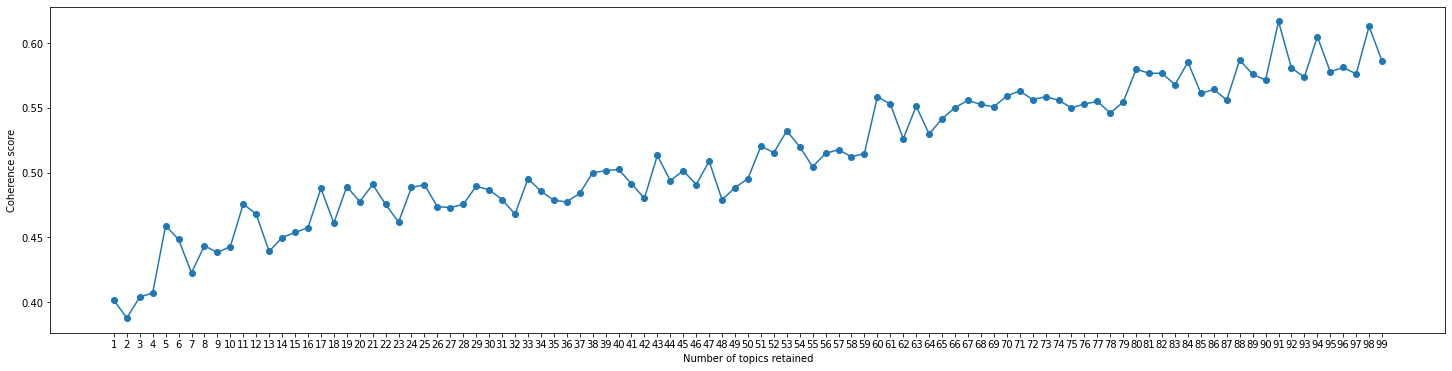

In [74]:
# plot coherence scores
fig = plt.figure(figsize=(25, 6))
ax = fig.add_subplot(111)
# plt.plot(np.array(list(loss.values())).astype(float))
ax.plot(list(cvs.keys()), list(cvs.values()), "o-")
ax.set_xlabel("Number of topics retained")
ax.set_ylabel("Coherence score")
ax.set_xticks(range(1, 100, 1))
plt.show()

In [75]:
topics_num = [92]
for i in topics_num:
  best_mdl = tp.LDAModel(k=i, corpus=corpus)
  for d in range(0, 100, 10):
      best_mdl.train(10)
      print("Iteration: {}\tLog-likelihood: {}".format(d, best_mdl.ll_per_word))
  # prepare data for visualization
  topic_term_dists = np.stack([best_mdl.get_topic_word_dist(k) for k in range(best_mdl.k)])
  doc_topic_dists = np.stack([doc.get_topic_dist() for doc in best_mdl.docs])
  doc_topic_dists /= doc_topic_dists.sum(axis=1, keepdims=True)
  doc_lengths = np.array([len(doc.words) for doc in best_mdl.docs])
  vocab = list(best_mdl.used_vocabs)
  term_frequency = best_mdl.used_vocab_freq

  # visualize the topics
  prepared_data = pyLDAvis.prepare(
      topic_term_dists, 
      doc_topic_dists, 
      doc_lengths, 
      vocab, 
      term_frequency,
      start_index=0, # tomotopy starts topic ids with 0, pyLDAvis with 1
      sort_topics=False # IMPORTANT: otherwise the topic_ids between pyLDAvis and tomotopy are not matching!
  )
  pyLDAvis.save_html(prepared_data, 'ldavis{}.html'.format(i))
  # # get summary of the best model
  # best_mdl.summary()

Iteration: 0	Log-likelihood: -10.54746012423151
Iteration: 10	Log-likelihood: -10.200595433038291
Iteration: 20	Log-likelihood: -10.030489019018043
Iteration: 30	Log-likelihood: -9.925915534236507
Iteration: 40	Log-likelihood: -9.845259896492932
Iteration: 50	Log-likelihood: -9.780257400945047
Iteration: 60	Log-likelihood: -9.719917992971942
Iteration: 70	Log-likelihood: -9.668372293129213
Iteration: 80	Log-likelihood: -9.627547226306932
Iteration: 90	Log-likelihood: -9.590846903310592


/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


In [ ]:
# topic model estimation (try 7,8,9,12)
best_mdl = tp.LDAModel(k=6, corpus=corpus)
for i in range(0, 100, 10):
    best_mdl.train(10)
    print("Iteration: {}\tLog-likelihood: {}".format(i, best_mdl.ll_per_word))
# get summary of the best model
best_mdl.summary()

Iteration: 0	Log-likelihood: -9.376981115855138
Iteration: 10	Log-likelihood: -9.165132967083652
Iteration: 20	Log-likelihood: -9.018529955486898
Iteration: 30	Log-likelihood: -8.93299417218789
Iteration: 40	Log-likelihood: -8.880746374344088
Iteration: 50	Log-likelihood: -8.844001457007263
Iteration: 60	Log-likelihood: -8.822804994211245
Iteration: 70	Log-likelihood: -8.805778555140419
Iteration: 80	Log-likelihood: -8.79411948533754
Iteration: 90	Log-likelihood: -8.780885049800284


In [ ]:
# prepare data for visualization
topic_term_dists = np.stack([best_mdl.get_topic_word_dist(k) for k in range(best_mdl.k)])
doc_topic_dists = np.stack([doc.get_topic_dist() for doc in best_mdl.docs])
doc_topic_dists /= doc_topic_dists.sum(axis=1, keepdims=True)
doc_lengths = np.array([len(doc.words) for doc in best_mdl.docs])
vocab = list(best_mdl.used_vocabs)
term_frequency = best_mdl.used_vocab_freq

# visualize the topics
prepared_data = pyLDAvis.prepare(
    topic_term_dists, 
    doc_topic_dists, 
    doc_lengths, 
    vocab, 
    term_frequency,
    start_index=0, # tomotopy starts topic ids with 0, pyLDAvis with 1
    sort_topics=False # IMPORTANT: otherwise the topic_ids between pyLDAvis and tomotopy are not matching!
)
pyLDAvis.save_html(prepared_data, 'ldavis.html')

In [ ]:
# visualise the topics
pyLDAvis.enable_notebook()
DATA_VIS = pyLDAvis.prepare(topic_term_dists, doc_topic_dists, doc_lengths, vocab,term_frequency)


In [ ]:
# word to topic probabilities
# an empty Pandas DF to populate
wt = pd.DataFrame()
# get word probabilities for each topic
for k in range(best_mdl.k):
    words, probs = [], []
    for word, prob in best_mdl.get_topic_words(k):
        words.append(word)
        probs.append(prob)
    tmp = pd.DataFrame(
        {
            "word": words,
            "prob": np.round(probs, 3),
            "k": np.repeat(k, len(words)),
            "sort": np.arange(0, len(words)),
        }
    )
    wt = pd.concat([wt, tmp], ignore_index=False)
    del tmp


# get topic probabilities for each document
td = pd.DataFrame(
    np.stack([doc.get_topic_dist() for doc in best_mdl.docs]),
    columns=["topic_{}".format(i + 1) for i in range(best_mdl.k)],
)

### BOW

### Word Embedding

### TF-IDF & Ngrams

In [ ]:
def simple_logistic_classify(x_train, x_test,y_train, y_test):
    model = LogisticRegression(C=1.0).fit(x_train, y_train)
    score = model.score(x_test, y_test)
    return score


In [ ]:
# select n-gram
# train model with different n-gram ranges
for N in tqdm.tqdm(range(1,5)):
    vectorizer = TfidfVectorizer(ngram_range=(1,N), max_features=2600)#TODO make a loop to find out the best value2600
    tfidf_output = vectorizer.fit_transform(tokens_list)
    x = vectorizer.get_feature_names_out()
    # contact the result of tfidf and index
    df_tfidfvect = pd.DataFrame(data = tfidf_output.toarray(),columns = x)

    # train model and generate predictions
    # split indepedent variable train and validation set
    x_train, x_test = train_test_split(df_tfidfvect, test_size=0.3, random_state=42)
    # split dependent varaible 
    y_train, y_test = train_test_split(review_cat, test_size=0.3, random_state=42)

    # compute f-1 score
    model = simple_logistic_classify(x_train, x_test,y_train, y_test)
    print('F-1 score of model with n-gram range of {}: {}'.format((1,N),model))



 25%|██▌       | 1/4 [00:03<00:10,  3.62s/it]

F-1 score of model with n-gram range of (1, 1): 0.7923768205763867


 50%|█████     | 2/4 [00:08<00:08,  4.25s/it]

F-1 score of model with n-gram range of (1, 2): 0.7914471645491168


 75%|███████▌  | 3/4 [00:17<00:06,  6.54s/it]

F-1 score of model with n-gram range of (1, 3): 0.7914471645491168


100%|██████████| 4/4 [00:30<00:00,  7.73s/it]

F-1 score of model with n-gram range of (1, 4): 0.7914471645491168


In [ ]:
# final n-gram is 1-gram
vectorizer = TfidfVectorizer(ngram_range=(1,1), max_features=2600)#
tfidf_output = vectorizer.fit_transform(tokens_list)
x = vectorizer.get_feature_names_out()
# contact the result of tfidf and index
df_tfidfvect = pd.DataFrame(data = tfidf_output.toarray(),columns = x)

### Length Analysis 

In [24]:
# create a table for tokenised data
df_mdy_train = pd.DataFrame({'imbd_user_review':mdy_train,'helpfulness_cat':review_cat})

In [25]:
# create column for length analysis outcome
df_mdy_train['word_count'] = df_mdy_train["imbd_user_review"].apply(lambda x: len(x))
df_mdy_train['char_count'] = df_mdy_train["imbd_user_review"].apply(lambda x: sum(len(word) for word in x))
df_mdy_train['sentence_count']  = review_text.apply(lambda x: len(str(x).split(".")))
df_mdy_train['avg_word_length'] = df_mdy_train['char_count'] / df_mdy_train['word_count']
df_mdy_train['avg_sentence_length'] = df_mdy_train['word_count'] / df_mdy_train['sentence_count']
df_mdy_train.head()

,imbd_user_review,helpfulness_cat,word_count,char_count,sentence_count,avg_word_length,avg_sentence_length
0,"[hard, delightful, adorable, movie, day, kid, ...",1.0,49,308,12,6.285714,4.083333
1,"[film, fade, haunt, masterpiece, silent, cinem...",1.0,151,902,20,5.973510,7.550000
2,"[view, movie, age, yrsprobably, movie, think, ...",1.0,18,113,5,6.277778,3.600000
3,"[doubt, resemble, complete, version, metropoli...",1.0,65,454,7,6.984615,9.285714
4,"[shocked, rivet, movie, doubt, scifi, movie, e...",1.0,42,252,6,6.000000,7.000000


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


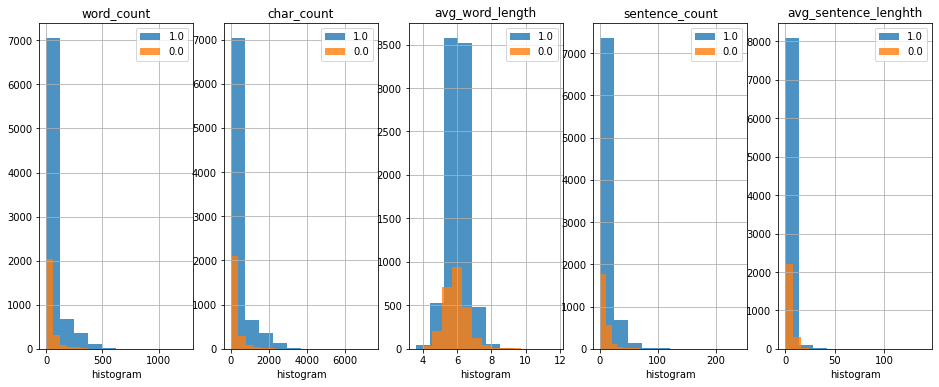

In [27]:
# visualize the distribution of the dataset
import seaborn as sns
x1,x2,x3,x4,x5,y = "word_count","char_count","avg_word_length","sentence_count","avg_sentence_length", "helpfulness_cat"
fig, ax = plt.subplots(nrows=1, ncols=5,figsize=(16,6))
for i in df_mdy_train[y].unique():
    sns.distplot(df_mdy_train[df_mdy_train[y]==i][x1], hist=True, kde=False, 
                 bins=10, hist_kws={"alpha":0.8}, 
                 axlabel="histogram", ax=ax[0])
    sns.distplot(df_mdy_train[df_mdy_train[y]==i][x2], hist=True, kde=False, 
                 bins=10, hist_kws={"alpha":0.8}, 
                 axlabel="histogram", ax=ax[1])
    sns.distplot(df_mdy_train[df_mdy_train[y]==i][x3], hist=True, kde=False, 
                 bins=10, hist_kws={"alpha":0.8}, 
                 axlabel="histogram", ax=ax[2])
    sns.distplot(df_mdy_train[df_mdy_train[y]==i][x4], hist=True, kde=False, 
                 bins=10, hist_kws={"alpha":0.8}, 
                 axlabel="histogram", ax=ax[3])
    sns.distplot(df_mdy_train[df_mdy_train[y]==i][x5], hist=True, kde=False, 
                 bins=10, hist_kws={"alpha":0.8}, 
                 axlabel="histogram", ax=ax[4])
ax[0].grid(True)
ax[0].legend(df_mdy_train[y].unique())
ax[0].set_title("word_count")
ax[1].grid(True)
ax[1].legend(df_mdy_train[y].unique())
ax[1].set_title("char_count")
ax[2].grid(True)
ax[2].legend(df_mdy_train[y].unique())
ax[2].set_title("avg_word_length")
ax[3].grid(True)
ax[3].legend(df_mdy_train[y].unique())
ax[3].set_title("sentence_count")
ax[4].grid(True)
ax[4].legend(df_mdy_train[y].unique())
ax[4].set_title("avg_sentence_lenghth")
plt.show()

### Dimension Reduction

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
# Use TSNE to reduce the demension to 2
TSNE_model = TSNE(n_components=3, random_state=0)
TSNE_result = TSNE_model.fit_transform(df_tfidfvect)


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [ ]:
TSNE_result_dfm = pd.DataFrame(TSNE_result, columns=['x', 'y','z'])
TSNE_result_dfm.head()

,x,y,z
0,35.296894,33.511894,-18.957975
1,43.665710,28.387058,6.490153
2,-3.823193,5.475380,-1.629816
3,20.880701,10.970266,-16.563936
4,27.041716,7.643130,-22.914478


### Combine features

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
scaler = MinMaxScaler()

In [ ]:
df3.iloc[:,2600:2603] = scaler.fit_transform(df3.iloc[:,2600:2603])

In [ ]:
df3 = pd.concat([df_tfidfvect, df_mdy_train.iloc[:,1:4]],axis="columns")

In [ ]:
df3.head()

,abandon,ability,abrams,absolute,absolutely,absurd,abuse,academy,accent,accept,...,yesterday,york,young,youth,youtube,zombie,zone,word_count,char_count,avg_word_length
0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.034426,0.038186,0.309850
1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.109836,0.114971,0.282353
2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.010656,0.012407,0.321429
3,0.0,0.0,0.0,0.0,0.0,0.0,0.321394,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.050820,0.061070,0.359944
4,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.027869,0.029915,0.289916


### Logistic Regression

In [ ]:
# split indepedent variable train and validation set
x_train, x_test = train_test_split(df_tfidfvect, test_size=0.3, random_state=42)

In [ ]:
# split dependent varaible 
y_train, y_test = train_test_split(review_cat, test_size=0.3, random_state=42)

In [ ]:
def simple_logistic_classify(x_train, y_train, x_test, y_test, _C=1):
    model = LogisticRegression(C=_C).fit(x_train, y_train)
    score = model.score(x_test, y_test)
    print('Test Score is', score)
    return model

In [ ]:
model = simple_logistic_classify(x_train, y_train, x_test, y_test)

Test Score is 0.7709947319491788


In [ ]:
# hype-parameter tuning 
from sklearn.model_selection import GridSearchCV
import sklearn
param_grid_ = {'C': [1e-5, 1e-3, 1e-1, 1e0, 1e1, 1e2]}
# bow_search = sklearn.model_selection.GridSearchCV(LogisticRegression(), cv=5, param_grid=param_grid_)
tfidf_search = sklearn.model_selection.GridSearchCV(LogisticRegression(), cv=5, param_grid=param_grid_)

In [ ]:
# confusion matrix and classification report(precision, recall, F1-score)
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
print(classification_report(y_test, model.predict(x_test)))
print(confusion_matrix(y_test, model.predict(x_test)))

              precision    recall  f1-score   support

         0.0       0.66      0.19      0.30       740
         1.0       0.80      0.97      0.88      2487

    accuracy                           0.79      3227
   macro avg       0.73      0.58      0.59      3227
weighted avg       0.77      0.79      0.75      3227

[[ 144  596]
 [  74 2413]]


### Pytorch

In [ ]:
!pip3 install torch==1.2.0+cu92 torchvision==0.4.0+cu92 -f https://download.pytorch.org/whl/torch_stable.html

In [ ]:
# load the data
from torchdata.datapipes.iter import IterableWrapper, FileOpener
import os
def get_name(path_and_stream):
     return os.path.basename(path_and_stream[0]), path_and_stream[1]
 datapipe1 = IterableWrapper(["1.csv", "empty.csv", "empty2.csv"])
 datapipe2 = FileOpener(datapipe1, mode="b")
 datapipe3 = datapipe2.map(get_name)
 csv_parser_dp = datapipe3.parse_csv()
 list(csv_parser_dp)
[['key', 'item'], ['a', '1'], ['b', '2'], []]

# iterator for training data
train_iter = iter(YelpReviewPolarity(split='train'))

# inspect the data

# exploit iter
next(train_iter)

# %% 
# buold the vocabulary

# load libraries
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
# tokenization
tokenizer = get_tokenizer('basic_english')
train_iter = YelpReviewPolarity(split='train')
# apply the tokenizer
# --+ custom function
def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)
        
# --+ deploy the tokenizer to get the vocabulary
vocab = build_vocab_from_iterator(yield_tokens(train_iter), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

# %%
# pre-processing pipelines

# tokenize Yelp reviews 
text_pipeline = lambda x: vocab(tokenizer(x))
# encode review labels
label_pipeline = lambda x: int(x) - 1

# %%
# data batches

# load libraries
import torch
from torch.utils.data import DataLoader
# set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# custom function
def collate_batch(batch):
    label_list, text_list, offsets = [], [], [0]
    for (_label, _text) in batch:
         label_list.append(label_pipeline(_label))
         processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
         text_list.append(processed_text)
         offsets.append(processed_text.size(0))
    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text_list = torch.cat(text_list)
    return label_list.to(device), text_list.to(device), offsets.to(device)
# deploy the function
train_iter = YelpReviewPolarity(split='train')
dataloader = DataLoader(train_iter, batch_size=8, shuffle=False, collate_fn=collate_batch)

# %%
# model creation

# load libraries
from torch import nn
# the class associated with the module
class TextClassificationModel(nn.Module):

    def __init__(self, vocab_size, embed_dim, num_class):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        return self.fc(embedded)
    
# %%
# model set up

# examples
train_iter = YelpReviewPolarity(split='train')
# classes
num_class = len(set([label for (label, text) in train_iter]))
# vocabulary size
vocab_size = len(vocab)
# ebedding bag size
emsize = 64
# model instantiation
model = TextClassificationModel(vocab_size, emsize, num_class).to(device)

# %%
# model training and evaluation

# load library 
import time
# custom function for training 
def train(dataloader):
    model.train()
    total_acc, total_count = 0, 0
    log_interval = 500
    start_time = time.time()

    for idx, (label, text, offsets) in enumerate(dataloader):
        optimizer.zero_grad()
        predicted_label = model(text, offsets)
        loss = criterion(predicted_label, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
        total_acc += (predicted_label.argmax(1) == label).sum().item()
        total_count += label.size(0)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches '
                  '| accuracy {:8.3f}'.format(epoch, idx, len(dataloader),
                                              total_acc/total_count))
            total_acc, total_count = 0, 0
            start_time = time.time()

# custom function for evaluation
def evaluate(dataloader):
    model.eval()
    total_acc, total_count = 0, 0

    with torch.no_grad():
        for idx, (label, text, offsets) in enumerate(dataloader):
            predicted_label = model(text, offsets)
            loss = criterion(predicted_label, label)
            total_acc += (predicted_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
    return total_acc/total_count

# %%
# training - validation split and model run

# load libraries 
from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset
# hyperparameters for the search
# --+ epoch
EPOCHS = 10 
# --+ learning rate
LR = 5  
# --+ batch size for training
BATCH_SIZE = 64 
# optimization
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
total_accu = None
# data handling
train_iter, test_iter = YelpReviewPolarity()
train_dataset = to_map_style_dataset(train_iter)
test_dataset = to_map_style_dataset(test_iter)
num_train = int(len(train_dataset) * 0.95)
split_train_, split_valid_ = \
    random_split(train_dataset, [num_train, len(train_dataset) - num_train])

train_dataloader = DataLoader(split_train_, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_batch)
valid_dataloader = DataLoader(split_valid_, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_batch)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                             shuffle=True, collate_fn=collate_batch)
# logging
for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    train(train_dataloader)
    accu_val = evaluate(valid_dataloader)
    if total_accu is not None and total_accu > accu_val:
      scheduler.step()
    else:
       total_accu = accu_val
    print('-' * 59)
    print('| end of epoch {:3d} | time: {:5.2f}s | '
          'valid accuracy {:8.3f} '.format(epoch,
                                           time.time() - epoch_start_time,
                                           accu_val))
    print('-' * 59)


# %%
# model evaluation

print('Checking the results of test dataset.')
accu_test = evaluate(test_dataloader)
print('test accuracy {:8.3f}'.format(accu_test))

# %%
# test on random unseen review

# labels
review_label = {1: "BAD",
                2: "GOOD"}

def predict(text, text_pipeline):
    with torch.no_grad():
        text = torch.tensor(text_pipeline(text))
        output = model(text, torch.tensor([0]))
        return output.argmax(1).item() + 1

ex_text_str = "."

model = model.to("cpu")

print("This is a %s Yelp reviews" %review_label[predict(ex_text_str, text_pipeline)])